In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
import time

In [2]:
transform =transforms.Compose([transforms.Resize((32,32)),#改变图片大小
                               transforms.ToTensor(),#将数据转为Tensor
                               transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])#mean和std，把数据变为[-1,1]
train_dataset=torchvision.datasets.ImageFolder(r'D:\车辆分类数据集\train/',transform=transform)
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True,num_workers=0)
test_dataset=torchvision.datasets.ImageFolder(r'D:\车辆分类数据集\test/',transform=transform)
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=64,shuffle=True,num_workers=0)
print(len(train_loader),len(test_loader))

14 8


In [3]:
class ConvModule(nn.Module):
    def __init__(self):
        super(ConvModule,self).__init__()
        #定义一个三层卷积
        self.conv=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32,
                      kernel_size=3,stride=1,padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32,out_channels=64,
                      kernel_size=3,stride=1,padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64,out_channels=128,
                      kernel_size=3,stride=1,padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        #输出层，将通道数变为分类数量
        self.fc=nn.Linear(128,num_classes)
        
    def forward(self,X):
        #图片先经过三层卷积，shape(batch_size,C_out,H,W)
        out=self.conv(X)
        #使用平均池化层将图片变为batch_size*128*1*1
        out=F.avg_pool2d(out,26)
        #将变量out压缩为batch*128
        out=out.squeeze()
        #进入全连接层，输出3维度
        out=self.fc(out)
        return out

In [4]:
# 训练函数
def train_epoch(net,data_loader,device):
    
    net.train()#指定当前为训练模式
    train_batch_num=len(data_loader)#记录batch数量
    total_loss=0#记录loss
    correct=0#记录样本被正确分类数量
    sample_num=0#记录样本总数
    
    #模型训练 反向传播更新参数
    #遍历每个batch进行训练
    for batch_idx,(data,target) in enumerate(data_loader):
        #将图片放入指定的device中，并转为浮点型
        data=data.to(device).float()
        #将图片标签放入指定的devce中，并转为浮点型
        target=target.to(device).long()
        #将当前梯度清零
        optimizer.zero_grad()
        #使用模型计算出结果
        output=net(data)
        #计算损失
        loss=criterion(output,target)
        #进行反向传播
        loss.backward()
        optimizer.step()
        
        
        #累加loss
        total_loss+=loss.item()
        #找出每个样本值最大的idx，即代表预测此图片属于哪个类别
        prediction=torch.argmax(output,1)
        #统计预测正确的类别数量
        correct+=(prediction==target).sum().item()
        #累加当前的样本总数
        sample_num+=len(prediction)
        
        
    #计算平均的loss与准确率
    loss=total_loss/train_batch_num
    acc=correct/sample_num
    return loss,acc

In [5]:
#测试函数
#在测试集上验证，计算Loss和Acc
def test_epoch(net, data_loader, device):
    net.eval()#指定当前模式为测试模式
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    #指定不进行梯度变化
    with torch.no_grad():
        for batch_idx, (data, target)in enumerate(data_loader):
            data = data.to(device).float()
            target = target.to(device).long()
            output = net(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            prediction = torch.argmax(output, 1)
            correct += (prediction ==target).sum().item()
            sample_num += len(prediction)
    loss = total_loss/test_batch_num
    acc = correct/sample_num
    return loss, acc

In [8]:
#vehicle_data数据对应的类别
classes=('car','bus','truck')
num_classes=3 #输出类别数
epochs = 30
lr = 0.005
device = torch.device('cpu')

#初始化模型
#net = MyConvModule().to(device)
net = ConvModule().to(device)
#使用两种方式定义模型

#损失函数为交叉熵损失函数
criterion=nn.CrossEntropyLoss()
#使用Adam优化器
optimizer=torch.optim.Adam(net.parameters(),lr)

In [21]:
# 存储每一个epoch的loss与acc的变化，便于后面可视化
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
print("batch_size=128")

#进行训练
start1=time.time()
for epoch in range(epochs):
    #在训练集上训练
    train_loss, train_acc = train_epoch(net,train_loader,device=device)
    #在测试集上验证
    test_loss, test_acc = test_epoch(net, test_loader , device=device)
    #保证各个指标
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    
    print(f'epoch:{epoch+1}\t train_loss:{train_loss:.4f}\t'
         f'train_acc:{train_acc:.4f}\t'
         f'test_loss:{test_loss:.4f}\t test_acc:{test_acc:.4f}')

batch_size=128
epoch:1	 train_loss:0.0234	train_acc:0.9929	test_loss:1.0881	 test_acc:0.8004
epoch:2	 train_loss:0.0255	train_acc:0.9929	test_loss:1.2614	 test_acc:0.7828
epoch:3	 train_loss:0.0320	train_acc:0.9894	test_loss:1.3826	 test_acc:0.7476
epoch:4	 train_loss:0.0233	train_acc:0.9882	test_loss:1.0993	 test_acc:0.7769
epoch:5	 train_loss:0.0274	train_acc:0.9894	test_loss:0.8635	 test_acc:0.8454
epoch:6	 train_loss:0.0197	train_acc:0.9941	test_loss:1.3513	 test_acc:0.7397
epoch:7	 train_loss:0.0144	train_acc:0.9965	test_loss:1.0273	 test_acc:0.8239
epoch:8	 train_loss:0.0187	train_acc:0.9965	test_loss:1.0538	 test_acc:0.8278
epoch:9	 train_loss:0.0172	train_acc:0.9953	test_loss:0.9389	 test_acc:0.8454
epoch:10	 train_loss:0.0241	train_acc:0.9905	test_loss:1.3641	 test_acc:0.7828
epoch:11	 train_loss:0.0322	train_acc:0.9929	test_loss:0.7066	 test_acc:0.8552
epoch:12	 train_loss:0.0398	train_acc:0.9846	test_loss:1.4057	 test_acc:0.7241
epoch:13	 train_loss:0.0237	train_acc:0.9941	t

In [9]:
time1=time.time()-start1
print('batch_size=128时的运行时间为：%.2f sec'%time1)#统计运行时间

batch_size=128时的运行时间为：897.96 sec


In [10]:
#读取数据

train_loader1=torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True,num_workers=0)
test_loader1=torch.utils.data.DataLoader(test_dataset,batch_size=64,shuffle=True,num_workers=0)
print(len(train_loader1),len(test_loader1))

14 8


In [11]:
# 存储每一个epoch的loss与acc的变化，便于后面可视化
train_loss_list1 = []
train_acc_list1 = []
test_loss_list1 = []
test_acc_list1 = []

print("batch_size=64")
#进行训练
start2=time.time()
for epoch1 in range(epochs):
    #在训练集上训练
    train_loss1, train_acc1 = train_epoch(net,train_loader1,device=device)
    #在测试集上验证
    test_loss1, test_acc1 = test_epoch(net, test_loader1 , device=device)
    #保证各个指标
    train_loss_list1.append(train_loss1)
    train_acc_list1.append(train_acc1)
    test_loss_list1.append(test_loss1)
    test_acc_list1.append(test_acc1)
    
    
    print(f'epoch:{epoch1+1}\t train_loss:{train_loss1:.4f}\t'
         f'train_acc:{train_acc1:.4f}\t'
         f'test_loss:{test_loss1:.4f}\t test_acc:{test_acc1:.4f}')

batch_size=64
epoch:1	 train_loss:0.6010	train_acc:0.7920	test_loss:1.1457	 test_acc:0.4579
epoch:2	 train_loss:0.3756	train_acc:0.8759	test_loss:1.4468	 test_acc:0.4540
epoch:3	 train_loss:0.3484	train_acc:0.8735	test_loss:0.8163	 test_acc:0.7476
epoch:4	 train_loss:0.3263	train_acc:0.8913	test_loss:1.1620	 test_acc:0.5479
epoch:5	 train_loss:0.3017	train_acc:0.8995	test_loss:0.6931	 test_acc:0.7182
epoch:6	 train_loss:0.2644	train_acc:0.9090	test_loss:1.2919	 test_acc:0.5910
epoch:7	 train_loss:0.2719	train_acc:0.9102	test_loss:1.2152	 test_acc:0.6477
epoch:8	 train_loss:0.2494	train_acc:0.9161	test_loss:1.4168	 test_acc:0.6243
epoch:9	 train_loss:0.2638	train_acc:0.9184	test_loss:0.6209	 test_acc:0.8121
epoch:10	 train_loss:0.2729	train_acc:0.9090	test_loss:0.6772	 test_acc:0.7828
epoch:11	 train_loss:0.2157	train_acc:0.9173	test_loss:0.7503	 test_acc:0.8121
epoch:12	 train_loss:0.2008	train_acc:0.9409	test_loss:0.5567	 test_acc:0.8200
epoch:13	 train_loss:0.1895	train_acc:0.9303	te

In [12]:
#读取数据

train_loader2=torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True,num_workers=0)
test_loader2=torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True,num_workers=0)
print(len(train_loader2),len(test_loader2))

27 16


In [13]:
# 存储每一个epoch的loss与acc的变化，便于后面可视化
train_loss_list2 = []
train_acc_list2 = []
test_loss_list2 = []
test_acc_list2 = []

print("batch_size=32")
#进行训练
start3=time.time()
for epoch2 in range(epochs):
    #在训练集上训练
    train_loss2, train_acc2 = train_epoch(net,train_loader2,device=device)
    #在测试集上验证
    test_loss2, test_acc2 = test_epoch(net, test_loader2 , device=device)
    #保证各个指标
    train_loss_list2.append(train_loss2)
    train_acc_list2.append(train_acc2)
    test_loss_list2.append(test_loss2)
    test_acc_list2.append(test_acc2)
    
    
    print(f'epoch:{epoch2+1}\t train_loss:{train_loss2:.4f}\t'
         f'train_acc:{train_acc2:.4f}\t'
         f'test_loss:{test_loss2:.4f}\t test_acc:{test_acc2:.4f}')

batch_size=32
epoch:1	 train_loss:0.1756	train_acc:0.9350	test_loss:1.1910	 test_acc:0.6849
epoch:2	 train_loss:0.1607	train_acc:0.9421	test_loss:1.2317	 test_acc:0.6497
epoch:3	 train_loss:0.1605	train_acc:0.9421	test_loss:1.2430	 test_acc:0.7182
epoch:4	 train_loss:0.1372	train_acc:0.9515	test_loss:1.1145	 test_acc:0.6791
epoch:5	 train_loss:0.1626	train_acc:0.9338	test_loss:1.4551	 test_acc:0.6634
epoch:6	 train_loss:0.1433	train_acc:0.9433	test_loss:0.7510	 test_acc:0.7750
epoch:7	 train_loss:0.1466	train_acc:0.9492	test_loss:0.9294	 test_acc:0.7632
epoch:8	 train_loss:0.1142	train_acc:0.9539	test_loss:1.0893	 test_acc:0.7730
epoch:9	 train_loss:0.1041	train_acc:0.9598	test_loss:2.1445	 test_acc:0.6732
epoch:10	 train_loss:0.1261	train_acc:0.9539	test_loss:1.5260	 test_acc:0.6575
epoch:11	 train_loss:0.1752	train_acc:0.9314	test_loss:0.8071	 test_acc:0.7789
epoch:12	 train_loss:0.1157	train_acc:0.9598	test_loss:0.9088	 test_acc:0.8102
epoch:13	 train_loss:0.0978	train_acc:0.9622	te

In [14]:
#读取数据

train_loader3=torch.utils.data.DataLoader(train_dataset,batch_size=256,shuffle=True,num_workers=0)
test_loader3=torch.utils.data.DataLoader(test_dataset,batch_size=256,shuffle=True,num_workers=0)
print(len(train_loader3),len(test_loader3))

4 2


In [15]:
# 存储每一个epoch的loss与acc的变化，便于后面可视化
train_loss_list3 = []
train_acc_list3 = []
test_loss_list3 = []
test_acc_list3 = []

print("batch_size=256")
#进行训练
start4=time.time()
for epoch3 in range(epochs):
    #在训练集上训练
    train_loss3, train_acc3 = train_epoch(net,train_loader3,device=device)
    #在测试集上验证
    test_loss3, test_acc3 = test_epoch(net, test_loader3 , device=device)
    #保证各个指标
    train_loss_list3.append(train_loss3)
    train_acc_list3.append(train_acc3)
    test_loss_list3.append(test_loss3)
    test_acc_list3.append(test_acc3)
    
    
    print(f'epoch:{epoch3+1}\t train_loss:{train_loss3:.4f}\t'
         f'train_acc:{train_acc3:.4f}\t'
         f'test_loss:{test_loss3:.4f}\t test_acc:{test_acc3:.4f}')

batch_size=256
epoch:1	 train_loss:0.0336	train_acc:0.9811	test_loss:1.3731	 test_acc:0.6986
epoch:2	 train_loss:0.0552	train_acc:0.9811	test_loss:1.2489	 test_acc:0.7456
epoch:3	 train_loss:0.0433	train_acc:0.9882	test_loss:1.1951	 test_acc:0.7573
epoch:4	 train_loss:0.0245	train_acc:0.9941	test_loss:1.1150	 test_acc:0.7710
epoch:5	 train_loss:0.0298	train_acc:0.9965	test_loss:0.9461	 test_acc:0.8063
epoch:6	 train_loss:0.0288	train_acc:0.9929	test_loss:0.8467	 test_acc:0.8219
epoch:7	 train_loss:0.0228	train_acc:0.9905	test_loss:0.8677	 test_acc:0.8337
epoch:8	 train_loss:0.0225	train_acc:0.9929	test_loss:0.9069	 test_acc:0.8258
epoch:9	 train_loss:0.0189	train_acc:0.9941	test_loss:0.9616	 test_acc:0.8004
epoch:10	 train_loss:0.0276	train_acc:0.9917	test_loss:0.9895	 test_acc:0.8082
epoch:11	 train_loss:0.0171	train_acc:0.9941	test_loss:1.0436	 test_acc:0.8082
epoch:12	 train_loss:0.0213	train_acc:0.9953	test_loss:1.0685	 test_acc:0.7945
epoch:13	 train_loss:0.0178	train_acc:0.9941	t

In [17]:
plt.rcParams["font.sans-serif"]=["SimHei"]#显示中文标签 

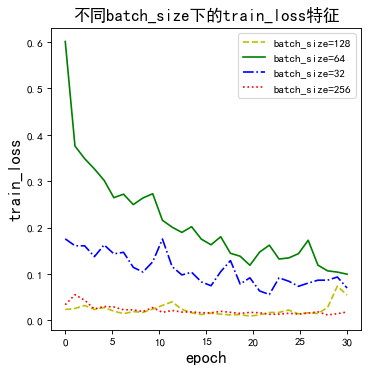

In [23]:
plt.rcParams["axes.unicode_minus"]=False

fig1 = plt.figure( figsize=(5, 5),dpi=80) 
#直接用plt.plot画图，第一个参数是表示横轴的序列，第二个参数是表示纵轴的序列   
x=np.linspace(0,len(train_loss_list),len(train_loss_list))
type1,=plt.plot(x,train_loss_list, color="y",label='batch_size=128',linestyle = "--")
type2,=plt.plot(x,train_loss_list1,color="g",label='batch_size=64',linestyle = "-")
type3,=plt.plot(x,train_loss_list2,color="b",label='batch_size=32',linestyle = "-.")
type4,=plt.plot(x,train_loss_list3,color="r",label='batch_size=256',linestyle = ":")

plt.xlabel('epoch',fontdict={'size':15})
plt.ylabel('train_loss',fontdict={'size':15})

plt.title('不同batch_size下的train_loss特征',fontdict={'size':15})
plt.legend((type1,type2,type3,type4),("batch_size=128","batch_size=64","batch_size=32","batch_size=256"))
#显示绘图结果
plt.show()

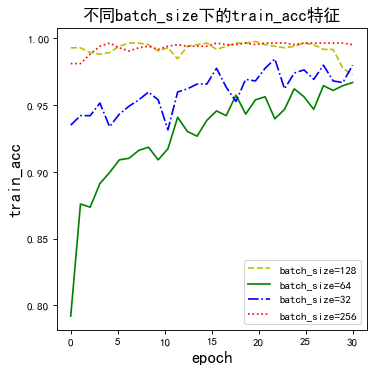

In [27]:
fig2 = plt.figure( figsize=(5, 5),dpi=80) 
x=np.linspace(0,len(train_acc_list),len(train_acc_list))
type5,=plt.plot(x,train_acc_list, color="y",label='batch_size=128',linestyle = "--")
type6,=plt.plot(x,train_acc_list1,color="g",label='batch_size=64',linestyle = "-")
type7,=plt.plot(x,train_acc_list2,color="b",label='batch_size=32',linestyle = "-.")
type8,=plt.plot(x,train_acc_list3,color="r",label='batch_size=256',linestyle = ":")

plt.xlabel('epoch',fontdict={'size':15})
plt.ylabel('train_acc',fontdict={'size':15})

plt.title('不同batch_size下的train_acc特征',fontdict={'size':15})
plt.legend((type5,type6,type7,type8),("batch_size=128","batch_size=64","batch_size=32","batch_size=256"))
#显示绘图结果
plt.show()

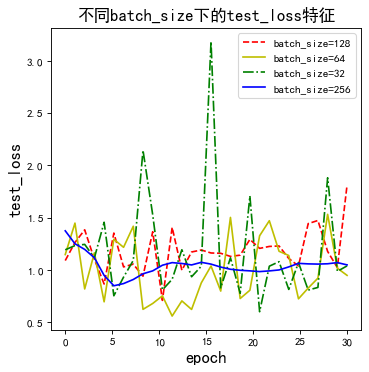

In [26]:
fig3 = plt.figure( figsize=(5, 5),dpi=80) 
#直接用plt.plot画图，第一个参数是表示横轴的序列，第二个参数是表示纵轴的序列   
x=np.linspace(0,len(test_loss_list),len(test_loss_list))
type9,=plt.plot(x,test_loss_list, color="y",label='batch_size=128',linestyle = "--")
type10,=plt.plot(x,test_loss_list1,color="g",label='batch_size=64',linestyle = "-")
type11,=plt.plot(x,test_loss_list2,color="b",label='batch_size=32',linestyle = "-.")
type12,=plt.plot(x,test_loss_list3,color="r",label='batch_size=256',linestyle = "-")

plt.xlabel('epoch',fontdict={'size':15})
plt.ylabel('test_loss',fontdict={'size':15})

plt.title('不同batch_size下的test_loss特征',fontdict={'size':15})
plt.legend((type9,type10,type11,type12),("batch_size=128","batch_size=64","batch_size=32","batch_size=256"))
#显示绘图结果
plt.show()

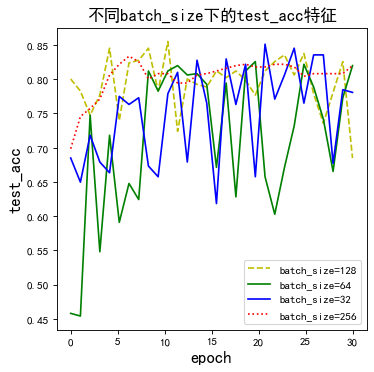

In [28]:
fig4 = plt.figure( figsize=(5, 5),dpi=80) 
#直接用plt.plot画图，第一个参数是表示横轴的序列，第二个参数是表示纵轴的序列   
x=np.linspace(0,len(test_acc_list),len(test_loss_list))
type13,=plt.plot(x,test_acc_list, color="y",label='batch_size=128',linestyle = "--")
type14,=plt.plot(x,test_acc_list1,color="g",label='batch_size=64',linestyle = "-")
type15,=plt.plot(x,test_acc_list2,color="b",label='batch_size=32',linestyle = "-")
type16,=plt.plot(x,test_acc_list3,color="r",label='batch_size=256',linestyle = ":")

plt.xlabel('epoch',fontdict={'size':15})
plt.ylabel('test_acc',fontdict={'size':15})

plt.title('不同batch_size下的test_acc特征',fontdict={'size':15})
plt.legend((type13,type14,type15,type16),("batch_size=128","batch_size=64","batch_size=32","batch_size=256"))
#显示绘图结果
plt.show()